In [143]:
import matplotlib.pyplot as plt
import numpy as np

In [144]:
number_of_files = 66 + 16

# 66 betrouwbare data, daarna veel ethanoldamp in de lucht (hoe kan dat nou?) 

data = []
data_T = [[], [], [], [], [], []]

for i in range(0, number_of_files+1):
    data.append([])
    t = []
    A0 = []
    A1 = []
    A2 = []
    # open_file = open(f"C:/Users/Michiel Erkamp/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    open_file = open(f"C:/Users/Michiel/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    for line in open_file:
        data_opgeknipt = line.split(',')
        try:
            data_opgeknipt = line.split(',')
            t.append(float(data_opgeknipt[0]))
            A0.append(float(data_opgeknipt[1]))
            A1.append(float(data_opgeknipt[2])) 
            A2.append(float(data_opgeknipt[3]))
        except:
            if data_opgeknipt[0] == "height of setup:":
                height = round(float(data_opgeknipt[1]) - 70, 2)
    open_file.close()

    A_avg = np.mean(np.array([A0, A1, A2]), axis=0)

    data[i-0].append([height] * len(t))
    data[i-0].append(t)
    data[i-0].append(A0)
    data[i-0].append(A1)
    data[i-0].append(A2)
    data[i-0].append(A_avg)

    data_T[0].append([height] * len(t))
    data_T[1].append(t)
    data_T[2].append(A0)
    data_T[3].append(A1)
    data_T[4].append(A2)
    data_T[5].append(A_avg)


data_all = [[], [], [], [], [], []]
for i in range(len(data_all)):
    for row in data_T[i]:
        data_all[i].extend(row)

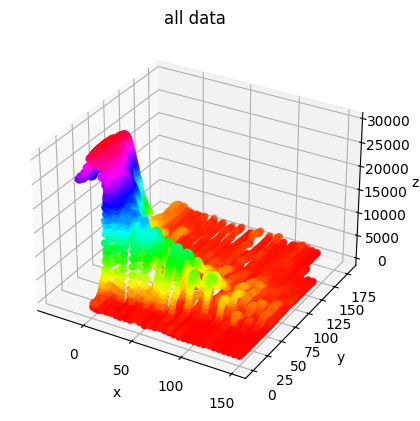

<Figure size 640x480 with 0 Axes>

In [145]:
indices = np.where(np.array(data_all[1]) < 180)[0]
# print(indices)

x = np.array(data_all[0])[indices]
y = np.array(data_all[1])[indices]
z = np.array(data_all[2])[indices]

ax = plt.axes(projection='3d')
ax.set_title('all data')
# ax.plot_trisurf(x,y,z, cmap='hsv')
ax.scatter3D(x,y,z, '.', c=z, cmap='hsv') # viridis
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
plt.show()
plt.clf()

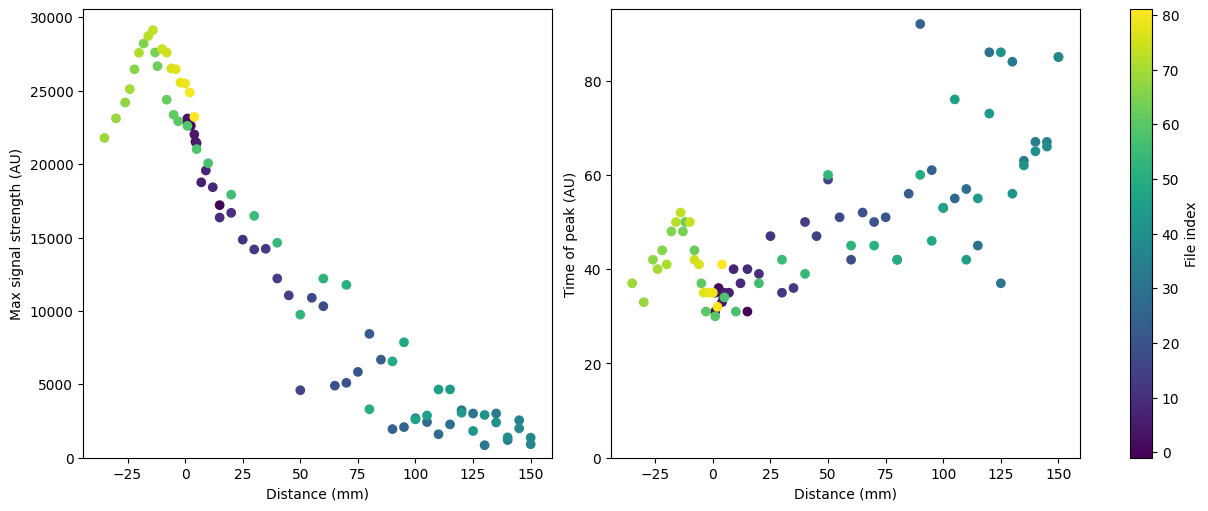

<Figure size 640x480 with 0 Axes>

In [146]:
height_top = []
time_top = []
signal_top = []


for measurement in data:
    index = np.where(measurement[2] == np.max(measurement[2]))[0][0]
    height_top.append(measurement[0][index])
    time_top.append(measurement[1][index])
    signal_top.append(measurement[2][index])

# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot on the left
sc = axes[0].scatter(height_top, signal_top, c=range(-1, number_of_files), cmap='viridis')
# axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("Distance (mm)")
axes[0].set_ylabel("Max signal strength (AU)")

# Plot on the right
axes[1].scatter(height_top, time_top, c=range(-1, number_of_files), cmap='viridis')
# axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("Distance (mm)")
axes[1].set_ylabel("Time of peak (AU)")

# Add a shared colorbar on the right side
cbar = fig.colorbar(sc, ax=axes, location='right', label='File index')

plt.show()
plt.clf()